# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

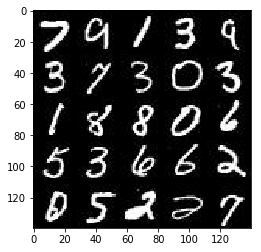

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

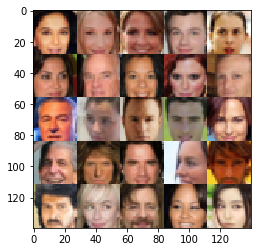

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    # alpha is set to be 0.2 here
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #  64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
          # leaky relu only
        x1 = tf.maximum(0.2*x1, x1)
        
        #  128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, use_bias=False, padding='same')
          # batch normalisation and leaky relu
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2*x2, x2)
        
        #  256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, use_bias=False, padding='same')
          # batch normalisation and leaky relu
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2*x3, x3)
        
        # flatten layer
        flat = tf.reshape(x3, (-1, 4*4*256))
        # output layer
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        # first fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # reshape to 4*4*512
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
          ## batch normalisation and relu
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2*x1, x1)
#         print(x1.shape)
        # 2nd layer - conv_t - change to (7*7*256)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, use_bias=False ,padding='valid')
          ## batch normalisation and relu
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2*x2, x2)
#         print(x2.shape)


        # 3rd layer - conv_t - change to (14*14*128)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, use_bias=False, padding='same')
          ## batch normalisation and relu
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2*x3, x3)
#         print(x3.shape)
        # output layer - (28*28*out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#         print(logits.shape)
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator output
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # discriminator output
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake) * 0.9))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, _ = model_inputs(data_shape[1], 
                                                      data_shape[2], 
                                                      data_shape[3], 
                                                      z_dim)
#     out_channel_dim = 1 if data_image_mode == 'L' else 3
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])#

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
#     saver = tf.train.Saver()
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

#     samples, losses = [], []
    steps = 0


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # sample random noise for Generator
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})


                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(steps+1, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 11/1... Discriminator Loss: 2.3046... Generator Loss: 0.4316
Epoch 21/1... Discriminator Loss: 3.5512... Generator Loss: 0.4365
Epoch 31/1... Discriminator Loss: 2.0795... Generator Loss: 0.4159
Epoch 41/1... Discriminator Loss: 1.6082... Generator Loss: 0.6615
Epoch 51/1... Discriminator Loss: 1.4214... Generator Loss: 1.1089
Epoch 61/1... Discriminator Loss: 1.4530... Generator Loss: 0.8816
Epoch 71/1... Discriminator Loss: 1.1765... Generator Loss: 0.9264
Epoch 81/1... Discriminator Loss: 1.1483... Generator Loss: 0.9627
Epoch 91/1... Discriminator Loss: 1.2694... Generator Loss: 0.7779
Epoch 101/1... Discriminator Loss: 1.5846... Generator Loss: 0.7238


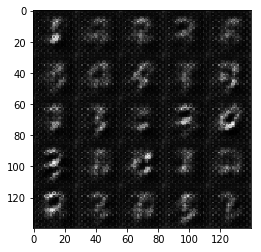

Epoch 111/1... Discriminator Loss: 1.4613... Generator Loss: 0.8134
Epoch 121/1... Discriminator Loss: 1.4504... Generator Loss: 0.8717
Epoch 131/1... Discriminator Loss: 1.3942... Generator Loss: 0.9635
Epoch 141/1... Discriminator Loss: 1.4428... Generator Loss: 0.7677
Epoch 151/1... Discriminator Loss: 1.3792... Generator Loss: 0.7727
Epoch 161/1... Discriminator Loss: 1.3831... Generator Loss: 0.8391
Epoch 171/1... Discriminator Loss: 1.3177... Generator Loss: 0.7294
Epoch 181/1... Discriminator Loss: 1.3545... Generator Loss: 0.8341
Epoch 191/1... Discriminator Loss: 1.3501... Generator Loss: 0.8932
Epoch 201/1... Discriminator Loss: 1.2833... Generator Loss: 0.8065


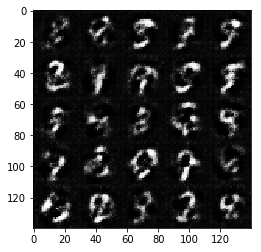

Epoch 211/1... Discriminator Loss: 1.2293... Generator Loss: 0.9559
Epoch 221/1... Discriminator Loss: 1.3044... Generator Loss: 1.3186
Epoch 231/1... Discriminator Loss: 1.3308... Generator Loss: 0.6925
Epoch 241/1... Discriminator Loss: 1.3125... Generator Loss: 1.1711
Epoch 251/1... Discriminator Loss: 1.2274... Generator Loss: 0.8420
Epoch 261/1... Discriminator Loss: 1.2354... Generator Loss: 1.0630
Epoch 271/1... Discriminator Loss: 1.2264... Generator Loss: 1.1254
Epoch 281/1... Discriminator Loss: 1.1411... Generator Loss: 0.9554
Epoch 291/1... Discriminator Loss: 1.3971... Generator Loss: 1.6396
Epoch 301/1... Discriminator Loss: 1.1286... Generator Loss: 1.0315


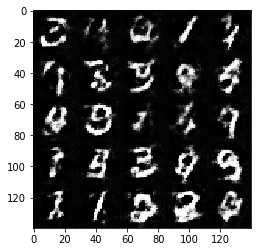

Epoch 311/1... Discriminator Loss: 1.2702... Generator Loss: 0.7452
Epoch 321/1... Discriminator Loss: 1.4402... Generator Loss: 0.5431
Epoch 331/1... Discriminator Loss: 1.2642... Generator Loss: 0.7271
Epoch 341/1... Discriminator Loss: 1.2562... Generator Loss: 0.7140
Epoch 351/1... Discriminator Loss: 1.3566... Generator Loss: 0.6451
Epoch 361/1... Discriminator Loss: 1.3298... Generator Loss: 0.6377
Epoch 371/1... Discriminator Loss: 1.3281... Generator Loss: 0.6600
Epoch 381/1... Discriminator Loss: 1.3700... Generator Loss: 1.1164
Epoch 391/1... Discriminator Loss: 1.3431... Generator Loss: 0.9877
Epoch 401/1... Discriminator Loss: 1.3399... Generator Loss: 0.8627


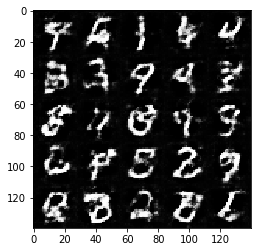

Epoch 411/1... Discriminator Loss: 1.4491... Generator Loss: 0.5304
Epoch 421/1... Discriminator Loss: 1.3915... Generator Loss: 0.5749
Epoch 431/1... Discriminator Loss: 1.2595... Generator Loss: 1.0054
Epoch 441/1... Discriminator Loss: 1.3094... Generator Loss: 0.8379
Epoch 451/1... Discriminator Loss: 1.4036... Generator Loss: 1.2025
Epoch 461/1... Discriminator Loss: 1.2979... Generator Loss: 0.6754
Epoch 471/2... Discriminator Loss: 1.4196... Generator Loss: 0.5496
Epoch 481/2... Discriminator Loss: 1.3111... Generator Loss: 0.6761
Epoch 491/2... Discriminator Loss: 1.2897... Generator Loss: 0.8890
Epoch 501/2... Discriminator Loss: 1.3533... Generator Loss: 0.9032


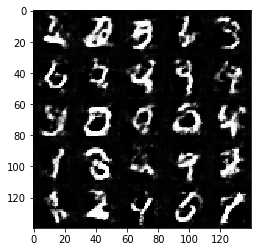

Epoch 511/2... Discriminator Loss: 1.4432... Generator Loss: 0.5331
Epoch 521/2... Discriminator Loss: 1.3197... Generator Loss: 0.6858
Epoch 531/2... Discriminator Loss: 1.3042... Generator Loss: 0.9462
Epoch 541/2... Discriminator Loss: 1.4775... Generator Loss: 1.4243
Epoch 551/2... Discriminator Loss: 1.2954... Generator Loss: 0.7810
Epoch 561/2... Discriminator Loss: 1.3819... Generator Loss: 0.6156
Epoch 571/2... Discriminator Loss: 1.4601... Generator Loss: 0.5317
Epoch 581/2... Discriminator Loss: 1.2873... Generator Loss: 0.8118
Epoch 591/2... Discriminator Loss: 1.3525... Generator Loss: 0.9582
Epoch 601/2... Discriminator Loss: 1.3894... Generator Loss: 0.5914


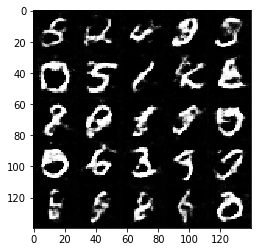

Epoch 611/2... Discriminator Loss: 1.3971... Generator Loss: 0.5732
Epoch 621/2... Discriminator Loss: 1.3146... Generator Loss: 0.8833
Epoch 631/2... Discriminator Loss: 1.4011... Generator Loss: 1.1851
Epoch 641/2... Discriminator Loss: 1.3118... Generator Loss: 0.7103
Epoch 651/2... Discriminator Loss: 1.3764... Generator Loss: 1.1959
Epoch 661/2... Discriminator Loss: 1.3292... Generator Loss: 0.8948
Epoch 671/2... Discriminator Loss: 1.3527... Generator Loss: 0.7739
Epoch 681/2... Discriminator Loss: 1.3408... Generator Loss: 0.6550
Epoch 691/2... Discriminator Loss: 1.4006... Generator Loss: 0.5868
Epoch 701/2... Discriminator Loss: 1.4538... Generator Loss: 0.5456


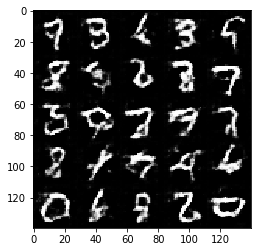

Epoch 711/2... Discriminator Loss: 1.3373... Generator Loss: 0.8180
Epoch 721/2... Discriminator Loss: 1.3087... Generator Loss: 0.8178
Epoch 731/2... Discriminator Loss: 1.3027... Generator Loss: 0.6498
Epoch 741/2... Discriminator Loss: 1.4809... Generator Loss: 1.2162
Epoch 751/2... Discriminator Loss: 1.4245... Generator Loss: 0.5630
Epoch 761/2... Discriminator Loss: 1.3144... Generator Loss: 0.8923
Epoch 771/2... Discriminator Loss: 1.3538... Generator Loss: 0.8302
Epoch 781/2... Discriminator Loss: 1.3577... Generator Loss: 0.6132
Epoch 791/2... Discriminator Loss: 1.3415... Generator Loss: 0.6460
Epoch 801/2... Discriminator Loss: 1.4300... Generator Loss: 0.5628


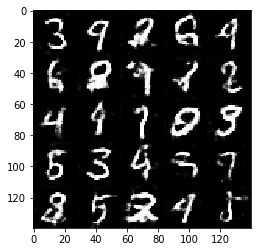

Epoch 811/2... Discriminator Loss: 1.3215... Generator Loss: 0.7064
Epoch 821/2... Discriminator Loss: 1.3923... Generator Loss: 0.5592
Epoch 831/2... Discriminator Loss: 1.2349... Generator Loss: 0.8241
Epoch 841/2... Discriminator Loss: 1.2981... Generator Loss: 0.7668
Epoch 851/2... Discriminator Loss: 1.2730... Generator Loss: 0.8177
Epoch 861/2... Discriminator Loss: 1.6736... Generator Loss: 0.4296
Epoch 871/2... Discriminator Loss: 1.3237... Generator Loss: 0.9373
Epoch 881/2... Discriminator Loss: 1.2920... Generator Loss: 0.8058
Epoch 891/2... Discriminator Loss: 1.6851... Generator Loss: 0.4291
Epoch 901/2... Discriminator Loss: 1.2890... Generator Loss: 0.9698


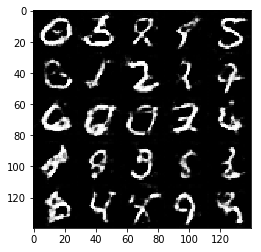

Epoch 911/2... Discriminator Loss: 1.5730... Generator Loss: 0.4624
Epoch 921/2... Discriminator Loss: 1.2906... Generator Loss: 0.6921
Epoch 931/2... Discriminator Loss: 1.2980... Generator Loss: 0.6966


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 11/1... Discriminator Loss: 3.3885... Generator Loss: 0.3617
Epoch 21/1... Discriminator Loss: 2.0729... Generator Loss: 0.6524
Epoch 31/1... Discriminator Loss: 1.7763... Generator Loss: 0.5694
Epoch 41/1... Discriminator Loss: 2.2346... Generator Loss: 0.5148
Epoch 51/1... Discriminator Loss: 2.1089... Generator Loss: 0.5617
Epoch 61/1... Discriminator Loss: 1.4628... Generator Loss: 1.1906
Epoch 71/1... Discriminator Loss: 0.9094... Generator Loss: 1.4069
Epoch 81/1... Discriminator Loss: 0.9456... Generator Loss: 1.4096
Epoch 91/1... Discriminator Loss: 0.8086... Generator Loss: 1.4429
Epoch 101/1... Discriminator Loss: 1.0013... Generator Loss: 1.4621


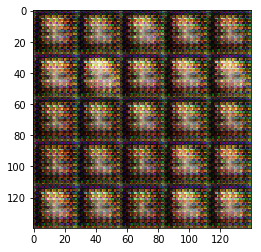

Epoch 111/1... Discriminator Loss: 2.3173... Generator Loss: 0.5729
Epoch 121/1... Discriminator Loss: 1.7655... Generator Loss: 0.6858
Epoch 131/1... Discriminator Loss: 1.4290... Generator Loss: 0.8496
Epoch 141/1... Discriminator Loss: 1.6360... Generator Loss: 0.7071
Epoch 151/1... Discriminator Loss: 1.1589... Generator Loss: 0.9711
Epoch 161/1... Discriminator Loss: 1.5717... Generator Loss: 0.9309
Epoch 171/1... Discriminator Loss: 1.7731... Generator Loss: 0.8756
Epoch 181/1... Discriminator Loss: 1.2044... Generator Loss: 0.9727
Epoch 191/1... Discriminator Loss: 1.2155... Generator Loss: 1.0101
Epoch 201/1... Discriminator Loss: 1.6370... Generator Loss: 0.7456


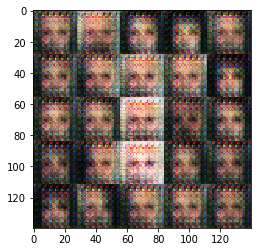

Epoch 211/1... Discriminator Loss: 2.2301... Generator Loss: 0.4766
Epoch 221/1... Discriminator Loss: 1.3076... Generator Loss: 0.9386
Epoch 231/1... Discriminator Loss: 1.6413... Generator Loss: 0.7151
Epoch 241/1... Discriminator Loss: 1.4716... Generator Loss: 0.7642
Epoch 251/1... Discriminator Loss: 1.4078... Generator Loss: 0.8375
Epoch 261/1... Discriminator Loss: 1.4739... Generator Loss: 0.7792
Epoch 271/1... Discriminator Loss: 1.3038... Generator Loss: 0.8429
Epoch 281/1... Discriminator Loss: 1.3886... Generator Loss: 0.8539
Epoch 291/1... Discriminator Loss: 1.7376... Generator Loss: 0.6506
Epoch 301/1... Discriminator Loss: 1.4316... Generator Loss: 0.7868


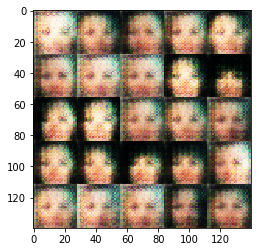

Epoch 311/1... Discriminator Loss: 1.5523... Generator Loss: 0.7992
Epoch 321/1... Discriminator Loss: 1.4708... Generator Loss: 0.7336
Epoch 331/1... Discriminator Loss: 1.6871... Generator Loss: 0.6445
Epoch 341/1... Discriminator Loss: 1.4499... Generator Loss: 0.7916
Epoch 351/1... Discriminator Loss: 1.4722... Generator Loss: 0.7715
Epoch 361/1... Discriminator Loss: 1.4075... Generator Loss: 0.8332
Epoch 371/1... Discriminator Loss: 1.8670... Generator Loss: 0.5942
Epoch 381/1... Discriminator Loss: 1.5491... Generator Loss: 0.7704
Epoch 391/1... Discriminator Loss: 1.7134... Generator Loss: 0.7050
Epoch 401/1... Discriminator Loss: 1.4201... Generator Loss: 0.7584


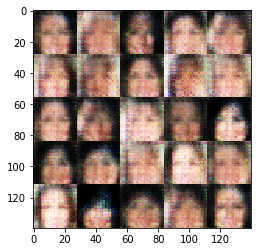

Epoch 411/1... Discriminator Loss: 1.5436... Generator Loss: 0.7749
Epoch 421/1... Discriminator Loss: 1.6969... Generator Loss: 0.6948
Epoch 431/1... Discriminator Loss: 1.5652... Generator Loss: 0.6741
Epoch 441/1... Discriminator Loss: 1.4539... Generator Loss: 0.8687
Epoch 451/1... Discriminator Loss: 1.4461... Generator Loss: 0.8105
Epoch 461/1... Discriminator Loss: 1.5167... Generator Loss: 0.7344
Epoch 471/1... Discriminator Loss: 1.4359... Generator Loss: 0.7958
Epoch 481/1... Discriminator Loss: 1.5132... Generator Loss: 0.7704
Epoch 491/1... Discriminator Loss: 1.4456... Generator Loss: 0.8524
Epoch 501/1... Discriminator Loss: 1.5587... Generator Loss: 0.7210


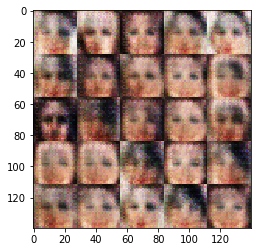

Epoch 511/1... Discriminator Loss: 1.3948... Generator Loss: 0.7698
Epoch 521/1... Discriminator Loss: 1.4313... Generator Loss: 0.7889
Epoch 531/1... Discriminator Loss: 1.4897... Generator Loss: 0.7662
Epoch 541/1... Discriminator Loss: 1.4891... Generator Loss: 0.7122
Epoch 551/1... Discriminator Loss: 1.3794... Generator Loss: 0.7782
Epoch 561/1... Discriminator Loss: 1.4963... Generator Loss: 0.7442
Epoch 571/1... Discriminator Loss: 1.4208... Generator Loss: 0.7592
Epoch 581/1... Discriminator Loss: 1.3370... Generator Loss: 0.8177
Epoch 591/1... Discriminator Loss: 1.5947... Generator Loss: 0.6965
Epoch 601/1... Discriminator Loss: 1.4946... Generator Loss: 0.7153


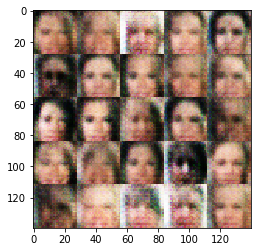

Epoch 611/1... Discriminator Loss: 1.4672... Generator Loss: 0.7728
Epoch 621/1... Discriminator Loss: 1.4985... Generator Loss: 0.7972
Epoch 631/1... Discriminator Loss: 1.4279... Generator Loss: 0.7557
Epoch 641/1... Discriminator Loss: 1.5050... Generator Loss: 0.7211
Epoch 651/1... Discriminator Loss: 1.4236... Generator Loss: 0.8031
Epoch 661/1... Discriminator Loss: 1.4060... Generator Loss: 0.7457
Epoch 671/1... Discriminator Loss: 1.4150... Generator Loss: 0.7965
Epoch 681/1... Discriminator Loss: 1.5071... Generator Loss: 0.7765
Epoch 691/1... Discriminator Loss: 1.4620... Generator Loss: 0.7291
Epoch 701/1... Discriminator Loss: 1.3623... Generator Loss: 0.7820


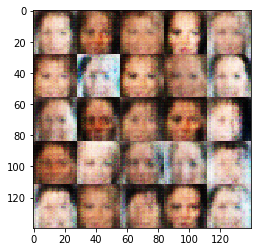

Epoch 711/1... Discriminator Loss: 1.4450... Generator Loss: 0.7774
Epoch 721/1... Discriminator Loss: 1.4169... Generator Loss: 0.7281
Epoch 731/1... Discriminator Loss: 1.4212... Generator Loss: 0.7849
Epoch 741/1... Discriminator Loss: 1.3938... Generator Loss: 0.8130
Epoch 751/1... Discriminator Loss: 1.4510... Generator Loss: 0.7392
Epoch 761/1... Discriminator Loss: 1.4318... Generator Loss: 0.7487
Epoch 771/1... Discriminator Loss: 1.3781... Generator Loss: 0.7345
Epoch 781/1... Discriminator Loss: 1.5594... Generator Loss: 0.7113
Epoch 791/1... Discriminator Loss: 1.4467... Generator Loss: 0.7489
Epoch 801/1... Discriminator Loss: 1.4902... Generator Loss: 0.7115


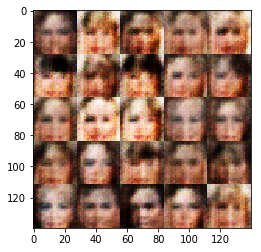

Epoch 811/1... Discriminator Loss: 1.3904... Generator Loss: 0.7913
Epoch 821/1... Discriminator Loss: 1.4193... Generator Loss: 0.7418
Epoch 831/1... Discriminator Loss: 1.4669... Generator Loss: 0.7848
Epoch 841/1... Discriminator Loss: 1.3523... Generator Loss: 0.7716
Epoch 851/1... Discriminator Loss: 1.4577... Generator Loss: 0.7805
Epoch 861/1... Discriminator Loss: 1.4044... Generator Loss: 0.7827
Epoch 871/1... Discriminator Loss: 1.4231... Generator Loss: 0.7580
Epoch 881/1... Discriminator Loss: 1.5007... Generator Loss: 0.7262
Epoch 891/1... Discriminator Loss: 1.3945... Generator Loss: 0.7901
Epoch 901/1... Discriminator Loss: 1.4498... Generator Loss: 0.7551


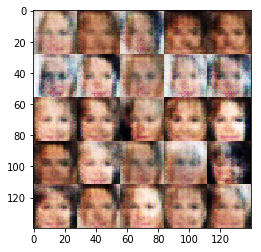

Epoch 911/1... Discriminator Loss: 1.4528... Generator Loss: 0.7611
Epoch 921/1... Discriminator Loss: 1.3879... Generator Loss: 0.7564
Epoch 931/1... Discriminator Loss: 1.4580... Generator Loss: 0.7533
Epoch 941/1... Discriminator Loss: 1.4222... Generator Loss: 0.7516
Epoch 951/1... Discriminator Loss: 1.4991... Generator Loss: 0.7330
Epoch 961/1... Discriminator Loss: 1.4177... Generator Loss: 0.7579
Epoch 971/1... Discriminator Loss: 1.4769... Generator Loss: 0.7358
Epoch 981/1... Discriminator Loss: 1.3704... Generator Loss: 0.7732
Epoch 991/1... Discriminator Loss: 1.4670... Generator Loss: 0.7370
Epoch 1001/1... Discriminator Loss: 1.4404... Generator Loss: 0.7701


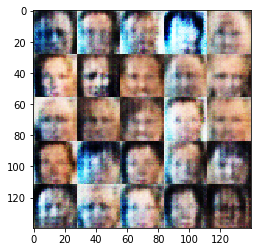

Epoch 1011/1... Discriminator Loss: 1.4084... Generator Loss: 0.7501
Epoch 1021/1... Discriminator Loss: 1.4476... Generator Loss: 0.7704
Epoch 1031/1... Discriminator Loss: 1.4637... Generator Loss: 0.7821
Epoch 1041/1... Discriminator Loss: 1.4294... Generator Loss: 0.7626
Epoch 1051/1... Discriminator Loss: 1.4380... Generator Loss: 0.7367
Epoch 1061/1... Discriminator Loss: 1.3832... Generator Loss: 0.7987
Epoch 1071/1... Discriminator Loss: 1.4333... Generator Loss: 0.7767
Epoch 1081/1... Discriminator Loss: 1.3941... Generator Loss: 0.7728
Epoch 1091/1... Discriminator Loss: 1.4271... Generator Loss: 0.7794
Epoch 1101/1... Discriminator Loss: 1.4248... Generator Loss: 0.7485


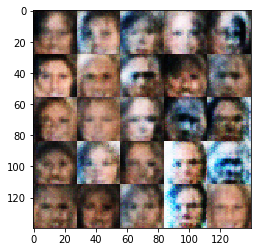

Epoch 1111/1... Discriminator Loss: 1.3878... Generator Loss: 0.8295
Epoch 1121/1... Discriminator Loss: 1.4195... Generator Loss: 0.7623
Epoch 1131/1... Discriminator Loss: 1.4366... Generator Loss: 0.7266
Epoch 1141/1... Discriminator Loss: 1.4152... Generator Loss: 0.7549
Epoch 1151/1... Discriminator Loss: 1.3962... Generator Loss: 0.7948
Epoch 1161/1... Discriminator Loss: 1.3708... Generator Loss: 0.7581
Epoch 1171/1... Discriminator Loss: 1.3827... Generator Loss: 0.7692
Epoch 1181/1... Discriminator Loss: 1.4704... Generator Loss: 0.7562
Epoch 1191/1... Discriminator Loss: 1.4357... Generator Loss: 0.7663
Epoch 1201/1... Discriminator Loss: 1.3854... Generator Loss: 0.7594


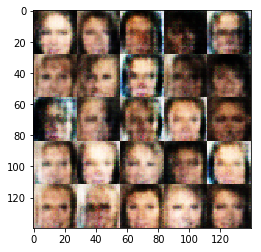

Epoch 1211/1... Discriminator Loss: 1.4767... Generator Loss: 0.7393
Epoch 1221/1... Discriminator Loss: 1.4306... Generator Loss: 0.7580
Epoch 1231/1... Discriminator Loss: 1.4671... Generator Loss: 0.7593
Epoch 1241/1... Discriminator Loss: 1.4229... Generator Loss: 0.8019
Epoch 1251/1... Discriminator Loss: 1.3696... Generator Loss: 0.8375
Epoch 1261/1... Discriminator Loss: 1.3753... Generator Loss: 0.7989
Epoch 1271/1... Discriminator Loss: 1.4848... Generator Loss: 0.7147
Epoch 1281/1... Discriminator Loss: 1.3604... Generator Loss: 0.7765
Epoch 1291/1... Discriminator Loss: 1.4889... Generator Loss: 0.7722
Epoch 1301/1... Discriminator Loss: 1.4576... Generator Loss: 0.7202


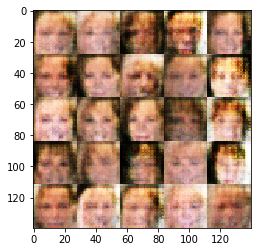

Epoch 1311/1... Discriminator Loss: 1.4589... Generator Loss: 0.7231
Epoch 1321/1... Discriminator Loss: 1.4217... Generator Loss: 0.7744
Epoch 1331/1... Discriminator Loss: 1.4210... Generator Loss: 0.8244
Epoch 1341/1... Discriminator Loss: 1.4024... Generator Loss: 0.7926
Epoch 1351/1... Discriminator Loss: 1.4205... Generator Loss: 0.7698
Epoch 1361/1... Discriminator Loss: 1.4807... Generator Loss: 0.7223
Epoch 1371/1... Discriminator Loss: 1.3969... Generator Loss: 0.7499
Epoch 1381/1... Discriminator Loss: 1.3927... Generator Loss: 0.7927
Epoch 1391/1... Discriminator Loss: 1.4407... Generator Loss: 0.7514
Epoch 1401/1... Discriminator Loss: 1.4755... Generator Loss: 0.6978


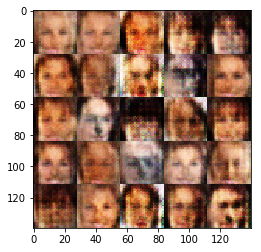

Epoch 1411/1... Discriminator Loss: 1.4373... Generator Loss: 0.7962
Epoch 1421/1... Discriminator Loss: 1.4217... Generator Loss: 0.7655
Epoch 1431/1... Discriminator Loss: 1.4078... Generator Loss: 0.7473
Epoch 1441/1... Discriminator Loss: 1.3907... Generator Loss: 0.8040
Epoch 1451/1... Discriminator Loss: 1.4433... Generator Loss: 0.7700
Epoch 1461/1... Discriminator Loss: 1.3986... Generator Loss: 0.7682
Epoch 1471/1... Discriminator Loss: 1.4253... Generator Loss: 0.7629
Epoch 1481/1... Discriminator Loss: 1.4318... Generator Loss: 0.7694
Epoch 1491/1... Discriminator Loss: 1.4054... Generator Loss: 0.7822
Epoch 1501/1... Discriminator Loss: 1.4209... Generator Loss: 0.8159


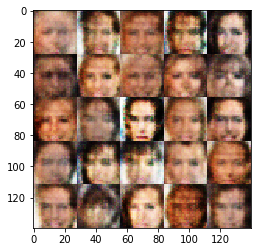

Epoch 1511/1... Discriminator Loss: 1.3829... Generator Loss: 0.7582
Epoch 1521/1... Discriminator Loss: 1.4279... Generator Loss: 0.7441


KeyboardInterrupt: 

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.